In [ ]:
# Introduction


This is a short overview over the features of the `quantumsim` package, from the perspective of a user.

## Circuits

`quantumsim.circuit` contains the `Circuit` class, which hold a set of named qubits (but not their state) and a sequence of 
gates that are applied to the qubits. As an example, a CNOT gate can be implemented like this:



In [1]:
import numpy as np
from quantumsim.circuit import Circuit

t1, t2 = 3000, 1500

c = Circuit(title="CNOT gate")
c.add_qubit("A", t1, t2)
c.add_qubit("B", t1, t2)

c.add_hadamard("B", time=0)
c.add_hadamard("B", time=40)
c.add_cphase("A", "B", time=20);

The circuit can be plotted, using `matplotlib`:

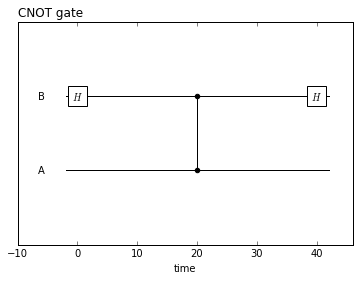

In [2]:
%matplotlib inline
c.plot();

# Measurements

Measurement gates are added as any other gate, but they require additional information in form of a "sampler".
The sampler specifies how the measurement outcomes (and declared outcomes) are determined.

Here, we use a "uniform noisy sampler", which will use a random number generator to sample from 
the projection probabilities (as expected in an experiment), but also sometimes (we choose 3%) declares the wrong outcome.

In order to obtain the declared outcome, we create a bit that obtains the measurement output. 
It is formally a qubit, but since is never put in a superposition, it will be efficiently implemented.


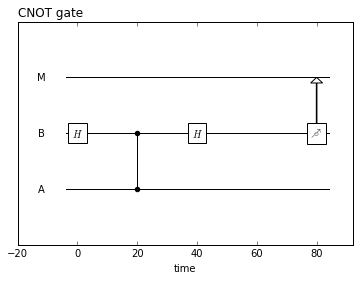

In [3]:
from quantumsim.circuit import uniform_noisy_sampler

c.add_qubit("M")

sampler = uniform_noisy_sampler(readout_error=0.03, seed=42)

c.add_measurement("B", time=80, output_bit="M", sampler=sampler);

c.plot();

# Rest gates

Gates are always assumed to be applied perfectly. 
Besides the declaration error of the measurement, we have not yet introduced any source of error.

The main source of error is in fact $T_1$ and $T_2$ decay. These are added automatically as rest gates inbetween any 
two other gates, using the `add_waiting_gates` function. Note that the measurement qubit has no rest gates added,
because we did not specify any `t1`, `t2` when creating it.

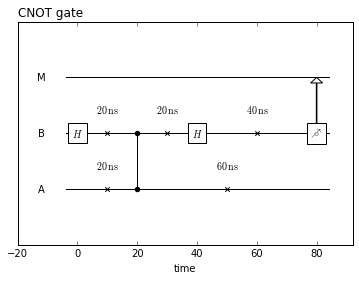

In [4]:
c.add_waiting_gates()
c.plot();

## Simulation

Now we are ready to simulate the circuit. 

The state of the qubits is held in a `quantumsim.sparsedm.SparseDM` object (a "sparse density matrix"), which is where the magic happens.

We create a `SparseDM` with the same qubit names as used in the circuit.

In [5]:
from quantumsim.sparsedm import SparseDM

sdm = SparseDM(c.get_qubit_names())

When loading `sparsedm`, an automatic check is performed whether an NVidia CUDA runtime and the pycuda package are available to perform computation on a GPU. If not, a cython-based backend is used. You can check which one is used:

In [6]:
import quantumsim.sparsedm
print("GPU is used:", quantumsim.sparsedm.using_gpu)

GPU is used: False


Each qubit of the `SparseDM` can be either "classical" or "quantum". If it is classical, its state is 0 or 1 (in computational basis), and not correlated to the state of any other qubit. Initially, all qubits are in the ground state. We flip the control bit A so that something happens.

In [7]:
sdm.classical['A'] = 1
print("initial state:", sdm.classical)

initial state: {'B': 0, 'A': 1, 'M': 0}


Now we apply the circuit. Before we can do that, we must instruct the circuit to bring its gates in the best correct order.

In [8]:
c.order()
c.apply_to(sdm)

Whenever a gate acts on a qubit, it becomes "quantum", meaning it becomes part of the big density matrix `sdm.full_dm`. Whenever a gate is measured and projected, it becomes classical again. After application of the circuit, the control bit A will thus be quantum. The measured bit B and the declared measurement outcome M should be 1 (unless an error occured), because the CNOT flips B.

In [9]:
print("classical bits after one round:", sdm.classical)

classical bits after one round: {'B': 1, 'M': 1}


We can obtain the probability that this measurement outcome actually would be observed:

In [10]:
print("probability:", sdm.trace())

probability: 0.94144220072


Let's run the whole circuit for a number of times and look at the declared outcome to see what happens.

In [11]:
measurements = []

for i in range(150):
    c.apply_to(sdm)
    measurements.append(sdm.classical['M'])

print("150 rounds of outcomes of CNOT+measurement:")
print(measurements)

150 rounds of outcomes of CNOT+measurement:
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


As we can see, the qubit B toggles each round as long as A is the 1 state, but after a while A decays and the flipping stops. 
Then, B is constant 1, but some point, B suffers a decay as well and is constant 0.

Then, an occasional declaration error is observed.

The probability that exactly this trace is observed is now vanishingly small:

In [12]:
print("probability:", sdm.trace())

probability: 1.87508569889e-11


We can keep the state in `sdm`, but reset this probability:

In [13]:
sdm.renormalize()
print("probability:", sdm.trace())

probability: 1.0


And finally apply one more round and thus obtain the conditional probability of the 152nd measurement outcome given the history of the previous outcomes:

In [14]:
c.apply_to(sdm)
print("152nd measurement:", sdm.classical['M'])
print("conditional probability:", sdm.trace())

152nd measurement: 0
conditional probability: 0.960523555257


The probability is larger than for the first round because the two qubits A and B are in the ground state now, and have less opportunity to decay.

# Using the backend

The `SparseDM` class is designed to keep track of repeated measurements during a circuit. If you only want to simulate a long sequence of gates on maybe one or two qubits, you can make use of the backend by hand and avoid overhead. A density matrix for one qubit can be created like this:

In [15]:
from quantumsim.dmcpu import Density

dm = Density(1)

The system is in the ground state:
    

In [16]:
dm.to_array()

array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j]])

One can operate gates on the density matrix directly by calling methods (this sequence does nothing):

In [17]:
phi = np.pi/2
dm.rotate_x(0, np.cos(phi/2), np.sin(phi/2))
dm.rotate_z(0, np.cos(phi), np.sin(phi)) # note that z takes a different angle than x and y!!!
#dm.rotate_y(0, np.cos(phi/2), np.sin(phi/2))

dm.to_array()



array([[ 0.5 +0.00000000e+00j,  0.5 +3.06161700e-17j],
       [ 0.5 -3.06161700e-17j,  0.5 +0.00000000e+00j]])

Here's a random clifford sequence with 0.01 t1 decay probability between each gate. We run 30 random rounds and 
print the probability for the bit to be in the up or down state, and the gate that was applied:

In [18]:
from functools import partial
dm = Density(1)

wait = partial(dm.amp_ph_damping, 0, gamma=0.01, lamda=0.0)

phi = np.pi/2

random_cliffords = [
    partial(gate, 0, np.cos(phi/2), np.sin(phi/2))
        for gate in [dm.rotate_x, dm.rotate_y]
        for phi in [np.pi, np.pi/2, -np.pi/2]
]

random_cliffords += [
    partial(dm.rotate_z, 0, np.cos(phi), np.sin(phi))
        for phi in [np.pi, np.pi/2, -np.pi/2]
]

for i in range(30):
    random = np.random.randint(len(random_cliffords))
    gate = random_cliffords[random]
    gate()
    wait()
    print(dm.get_diag(), gate.func.__name__)

[ 1.  0.] rotate_z
[ 1.  0.] rotate_z
[ 0.505  0.495] rotate_x
[ 0.99751878  0.00248122] rotate_x
[ 0.50007481  0.49992519] rotate_x
[ 0.99507469  0.00492531] rotate_x
[ 0.505  0.495] rotate_y
[ 0.50005  0.49995] rotate_y
[ 0.50507296  0.49492704] rotate_x
[ 0.49997777  0.50002223] rotate_y
[ 0.505022  0.494978] rotate_x
[ 0.50002822  0.49997178] rotate_y
[ 0.50497207  0.49502793] rotate_y
[ 0.50504827  0.49495173] rotate_x
[ 0.50000221  0.49999779] rotate_y
[ 0.50987312  0.49012688] rotate_x
[ 0.50500218  0.49499782] rotate_x
[ 0.5147254  0.4852746] rotate_x
[ 0.49042186  0.50957814] rotate_x
[ 0.49551764  0.50448236] rotate_z
[ 0.50056246  0.49943754] rotate_z
[ 0.05046234  0.94953766] rotate_y
[ 0.95004229  0.04995771] rotate_x
[ 0.50555127  0.49444873] rotate_y
[ 0.06169144  0.93830856] rotate_y
[ 0.49953179  0.50046821] rotate_y
[ 0.50453647  0.49546353] rotate_z
[ 0.50949111  0.49050889] rotate_z
[ 0.5143962  0.4856038] rotate_z
[ 0.93029036  0.06970964] rotate_x


In [23]:
from functools import partial
mean_data = []
std_data = []
num_iter = 1000
gate_time = 20
for num_cliffords in [1,2,5,10,20,40,80]+list(range(100,3001,50)):
    print(num_cliffords)
    data = []
    for _ in range(num_iter):

        dm = Density(1)

        T1 = np.random.normal(22700,2700)
        if T1 <= 0 or T1 > 50000:
            continue
        Tphi = 17000

        gamma = 1-np.exp(-gate_time/T1)
        lamda = 1-np.exp(-gate_time/Tphi)
        wait = partial(dm.amp_ph_damping, 0, gamma=gamma, lamda=lamda)

        gamma2 = 1 - np.exp(-gate_time/(2*T1))
        lamda2 = 1 - np.exp(-gate_time/(2*Tphi))
        wait2 = partial(dm.amp_ph_damping, 0, gamma=gamma2, lamda=lamda2)


        random_cliffords = [
            partial(gate, 0, np.cos(phi/2), np.sin(phi/2))
                for gate in [dm.rotate_x, dm.rotate_y]
                for phi in [np.pi, np.pi/2, -np.pi/2]
        ]

        random_cliffords += [
            partial(dm.rotate_z, 0, np.cos(phi), np.sin(phi))
                for phi in [np.pi, np.pi/2, -np.pi/2]
        ]

        # Data for recovery of the final state
        clifford_tags = ['xpi','xpi2','xpi2m','ypi','ypi2','ypi2m','zpi','zpi2','zpi2m']
        state_tags = ['+z','-z','+x','-x','+y','-y']
        recovery_tags = [6, 0, 4, 5, 2, 1]
        transfer_matrix = [[1, 0, 2, 3, 5, 4], [4, 5, 2, 3, 1, 0], [5, 4, 2, 3, 0, 1], 
                           [1, 0, 3, 2, 4, 5], [3, 2, 0, 1, 4, 5], [2, 3, 1, 0, 4, 5],
                           [0, 1, 3, 2, 5, 4], [0, 1, 5, 4, 2, 3], [0, 1, 4, 5, 3, 2]]
        state = 0

        wait2()
        for i in range(num_cliffords):
            random = np.random.randint(len(random_cliffords))
            gate = random_cliffords[random]
            state = transfer_matrix[random][state]
            gate()
            wait()
        final_gate = random_cliffords[recovery_tags[state]]
        final_gate()
        wait2()
        data.append(dm.get_diag()[0])
    mean_data.append(np.mean(data))
    std_data.append(np.std(data))

1
2
5
10
20
40
80
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000


In [35]:
plt.rcParams['font.family'] = 'serif'
#plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 24
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 8.0
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 4.0
plt.rcParams['xtick.minor.width'] = 0.7
plt.rcParams['ytick.major.size'] = 8.0
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.size'] = 4.0
plt.rcParams['ytick.minor.width'] = 0.7
plt.rcParams['text.usetex'] = True
plt.rcParams["figure.facecolor"] = "w"
plt.rcParams["figure.edgecolor"] = "w"

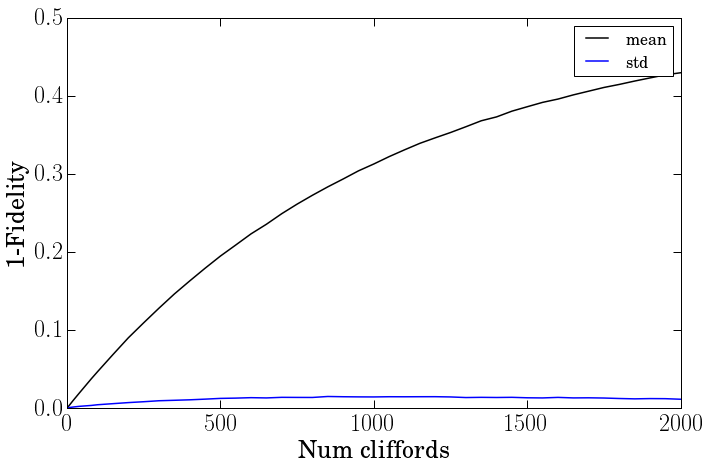

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize=(11,7))
y1, =plt.plot([1,2,5,10,20,40,80]+list(range(100,3001,50)),[1-x for x in mean_data],'k')
y2, =plt.plot([1,2,5,10,20,40,80]+list(range(100,3001,50)),std_data,'b')
plt.ylim(0,0.5)
plt.xlim(0,2000)
plt.legend([y1,y2],['mean','std'])
plt.xlabel('Num cliffords')
plt.ylabel('1-Fidelity')